## Vegetation mapping

In this exercise you will work on a hyperspectral image.  

You will hand in a short report on the findings from each step, and attach the python code in the end.

The image is obtained from plane with a hyperspectral camera from NEO (Norsk ElektroOptikk) in the wavelength interval 400-100 nm. The image is from Sandvika and belongs to Bærum Kommune.

The file is named sandvika.npy

You will also need the header file with wavelengths for each band number called Visnir.hdr

 

1. First you need to load the image into Python, as shown in the lecture notes, there is an example python script here.

2. Write a function the defines the band number for blue (440 nm), green (535 nm), red (645 nm) and NIR (800 nm) by using the wavelength info in the  header file. 

3. Display an RGB image from the hyperspectral image and included it in your report.

4. Write a function that computes the NDVI index (Normalized Difference Vegetation Index)

      NDVI = (NIR-Red)/(NIR+Red)

5. Display the NDVI image in a sensible range and include it in  the report.

6. Select a point with 
- 1)vegetation, 
- 2)one with asphalt(pich dhalai er kalo ta) and 
- 3)one with a roof and\

plot the spectra and show them in the report.  

7. Compute and display a histogram of all the NDVI values in the image, include it in the report.

8. Make a threshold of NDVI > 0.6 and set all values with NDVI > 0.6 to zero. Display this image. What do you see ? (include in report)

9. Can you use this information to determine the  fraction area of the image that has vegetation ?

10. Carry out a principal component analysis (PCA) of the image, using the pca function from the Spectral Python.\
Study the score images  and loading plots.\
Can any of the first 3 components be used to identify vegetation in the image ? Include the **first 3 score** images and loading plots in your report.

11. Carry out a k-means clustering on a selected number of principal component score image, try k-means with 2, 3, 4 and 5 classes.  \
How many components would you chose in order to group all the pixels with vegetation ?  Include one of the k-mean calculations in the report.

12. Which method to determine the amount of vegetation do you think is most appropriate in this hyperspectral image ? Describe why you prefer one method before another.

 
13. Carry out a Gaussian Maximum Likelihood Classification (GMLC) with the selected classes.
  Suggestions for classes can be:
    1 – grass
    2 – asphalt
    3 – water
    4 – solar panel
    5 - the darker road in front of the solar panels
Feel fre to experiment with classes.
What do you think about the results ?
Deadline is November 28th.

Good luck! 

In [1]:
# Importing all the necessary modules
from spectral import *
import numpy as np
import matplotlib.pyplot as plt
import skimage
import math

## Task1 : Load image
First you need to load the image into Python, as shown in the lecture notes, there is an example python script here.

In [2]:
hyperim = np.load("sandvika.npy")

# Task 2: get the bands
Write a function the defines the band number for blue (440 nm), green (535 nm), red (645 nm) and NIR (800 nm) by using the wavelength info in the header file.

In [3]:
# Function for finding the required bands
def find_bands(all_wavelengths,required_wavelengths):
    required_bands = {}
    
    for wavelength in required_wavelengths.keys():
            min_distance = None
            min_wave_val = None
            band = None
            for index, wave_val in enumerate(all_wavelengths): 
                current_distance = abs(wavelength - wave_val)
                if min_distance == None:
                    min_distance = current_distance
                    min_wave_val = wave_val
                    band = index+1
                elif current_distance> min_distance:
                    break
                elif current_distance< min_distance:
                    min_distance = current_distance
                    min_wave_val = wave_val
                    band = index +1    

            band_name = required_wavelengths[wavelength]
            required_bands[band_name]=band        
    return required_bands

In [4]:
# Calling the function to get required wavelength bands
wavelength = envi.read_envi_header('Visnir.hdr')['wavelength']
all_wavelengths = [float(i) for i in wavelength]
required_wavelengths = {440:"blue", 535:'green', 645:'red', 800:'NIR'}
required_bands = find_bands(all_wavelengths, required_wavelengths)
print("required_bands", required_bands)

required_bands {'blue': 11, 'green': 41, 'red': 76, 'NIR': 124}


In [5]:
#Organising the RGB bands in list format
print("required_bands", required_bands)   
RGB_bands = [required_bands['red'],required_bands['green'],required_bands['blue']]
print("RGB_bands", RGB_bands)
NIR_band = required_bands['NIR']
print("NIR_band", NIR_band)
red_band = required_bands['red']
print("red_band", red_band)

required_bands {'blue': 11, 'green': 41, 'red': 76, 'NIR': 124}
RGB_bands [76, 41, 11]
NIR_band 124
red_band 76


# Task3 Display the RGB Image:
Display an RGB image from the hyperspectral image and included it in your report.

link: https://www.spectralpython.net/class_func_ref.html

#### Diplaying RGB image with only 1 band for each color

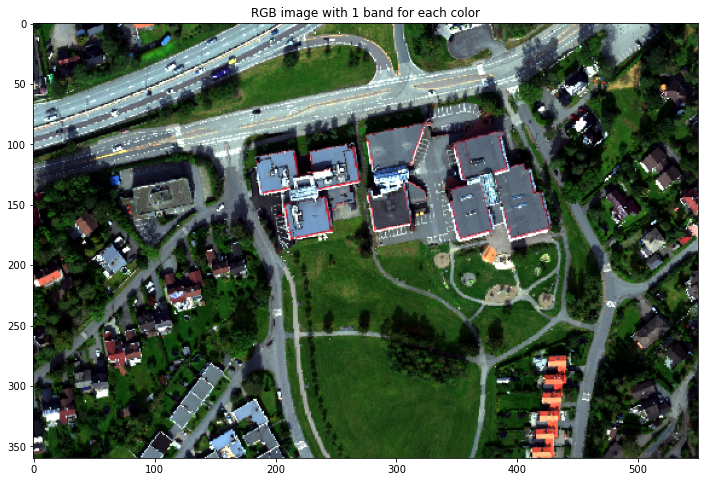

In [6]:
imshow(hyperim, bands = RGB_bands, stretch=((0.02,0.98),(0.02,0.98),(0.02,0.98)), figsize=(12,8))
plt.title("RGB image with 1 band for each color")
plt.show()

#### Diplaying RGB image with an average of range of bands (10 bands) for each color

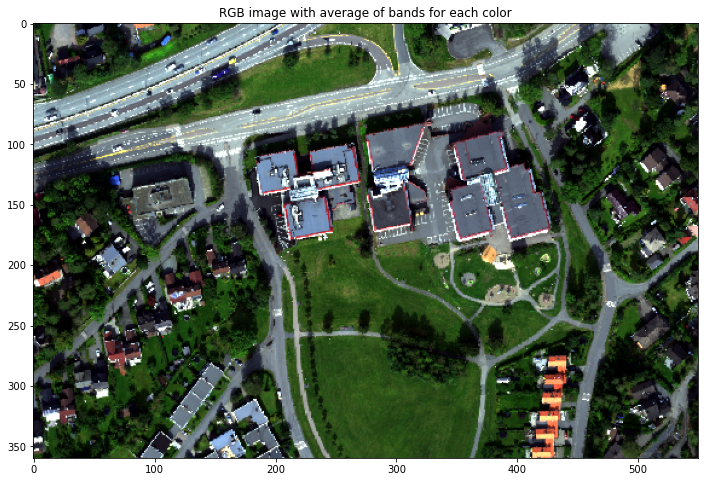

In [7]:
RGB_average_hyperim = hyperim[:, :, :]

blue_avg = RGB_average_hyperim [:, :, 10:20 ].mean(axis=2)
green_avg = RGB_average_hyperim [:, :, 40:50 ].mean(axis=2)
red_avg = RGB_average_hyperim [:, :, 65:75 ].mean(axis=2)

shape = RGB_average_hyperim.shape
RGB_avg = np.zeros([shape[0], shape[1], 3])
RGB_avg[:, :, 0] = red_avg
RGB_avg[:, :, 1] = green_avg
RGB_avg[:, :, 2] = blue_avg

imshow(RGB_avg, stretch=((0.02,0.98),(0.02,0.98),(0.02,0.98)), figsize=(12,8))
plt.title("RGB image with average of bands for each color")
plt.show()

#### Comment on the RGB image with 1 band and the RGB image with the average of bands.
Each of the color belongs to multiple bands, so instead of taking just 1 band, if we take a range of bands(10 bands) belonging to that color, the image quality is improved.

# Task4- NDVI Index calculation

4. Write a function that computes the NDVI index (Normalized Difference Vegetation Index)

      NDVI = (NIR-Red)/(NIR+Red)

#### NDVI calculating using the equation/formula

In [8]:
np.seterr(invalid='ignore') #ignoring the Nan values
ndvi_image_manual = (hyperim[:,:,NIR_band]-hyperim[:,:,red_band])/(hyperim[:,:,NIR_band]+hyperim[:,:,red_band])

#### NDVI calculating using the python function

In [9]:
np.seterr(invalid='ignore') #ignoring the Nan values
ndvi_image_python = ndvi(hyperim,red_band, NIR_band)

# Task5- NDVI Image
Display the NDVI image in a sensible range and include it in  the report.

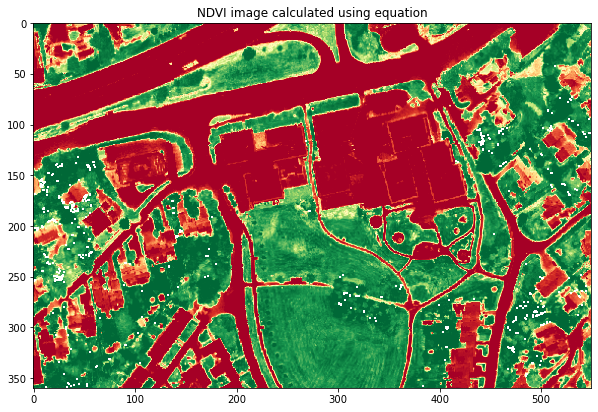

In [10]:
# NDVI image calculated using equation
plt.figure(figsize=(10,8))
plt.imshow(ndvi_image_manual,vmin=0.1,vmax=0.9, cmap='RdYlGn') 
plt.title("NDVI image calculated using equation")
plt.show()

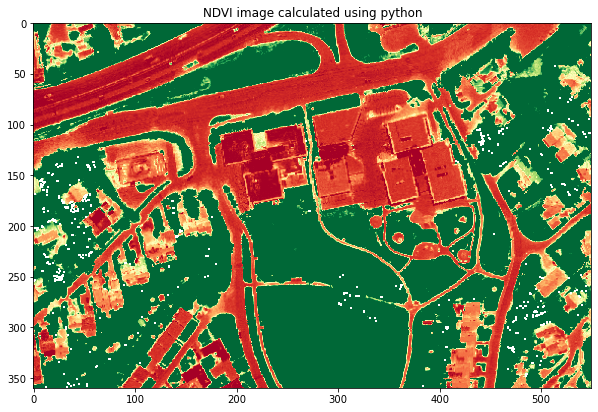

In [11]:
# NDVI image calculated using python
plt.figure(figsize=(10,8))
plt.imshow(ndvi_image_python,vmin=0,vmax=0.6, cmap='RdYlGn') 
plt.title("NDVI image calculated using python")
plt.show()


#### Comment on the NDVI Image

- NDVI index is from -1 to 1. Starting from NDVI 0.3, everything is considered to be vegetation. Different plants have different NDVI depening on their health. Extremely healthy plants with high chlorophyll will have NVDI 1. Everything that have a NDVI below 0.3 is almost a dead plant with low Chlorophyll level or an object.
- From the images below, we can see that all the vegetation has been displayed in green and rest in red.
- NDVI value calculated in both both ways using the python built-in function and formula are same.


# Task6: Spectra image

Select a point with

- 1)vegetation,
- 2)one with asphalt(pich dhalai er kalo ta) and
- 3)one with a roof and\
- plot the spectra and show them in the report.

## Spectra image with points (vegetation, asphalt and roof) 

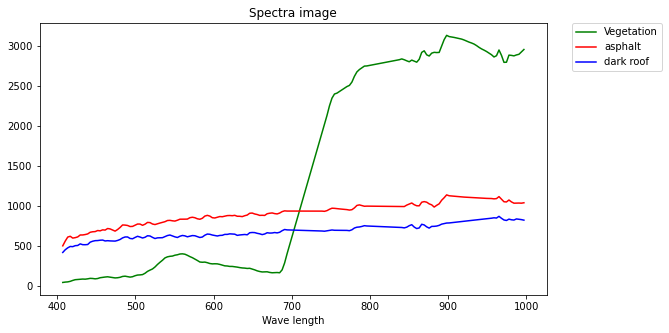

In [12]:
vegetation = np.array(hyperim[278,245,:].reshape(-1,1)) # grass
asphalt = np.array(hyperim[79,157,:].reshape(-1,1))#asphalt light
roof_dark = np.array(hyperim[99,280,:].reshape(-1,1)) # roof dark

fig, ax_dict = plt.subplot_mosaic([ ['bottom', 'BLANK']], empty_sentinel="BLANK", figsize = (20, 5))

ax_dict['bottom'].plot(all_wavelengths,  vegetation, color = 'g', label='Vegetation')
ax_dict['bottom'].plot(all_wavelengths, asphalt,color = 'r', label='asphalt')
ax_dict['bottom'].plot(all_wavelengths, roof_dark,color = 'b',label='dark roof')
# Place a legend to the right of this smaller subplot.
ax_dict['bottom'].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


plt.title("Spectra image")
plt.xlabel("Wave length")
# plt.ylabel("Pixel count")
plt.show()

#### Comment on the Spectra image
- We know the the Red color has the waves length from 620 to 720 nm. (Source: https://www.elprocus.com/wavelength-of-red-light/) and NIR has wavelengths from 800 to 2,500 nm. Anything that has wavelength starting after red(720nm) and before NIR(800nm) are considered vegetation.

- From the spectrum image, we can see that 
  - both asphalt and roof has very flat length, without any spikes in the vegetation considered wavelength zone.  
  - Grass(vegatation) has a spike from approximately 680nm which continued till the end, proving the presense of chlorophyll in that range of wavelength.


## Mean spectrum of 20x20 pixels for each material/region

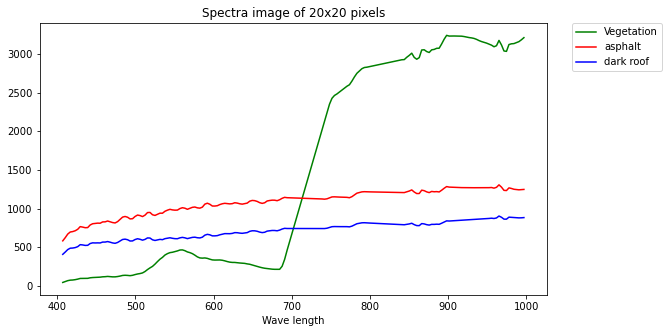

In [13]:
vegetation1 = hyperim[290:310, 275:295,:].mean(axis=0) # grass
vegetation = vegetation1.mean(axis=0).reshape(-1,1) # grass

asphalt1 = hyperim[85:105, 150:170,:].mean(axis=0) # asphalt
asphalt = asphalt1.mean(axis=0).reshape(-1,1) # asphalt

roof_dark1 = hyperim[90:110, 300:320,:].mean(axis=0) #roof_dark1
roof_dark = roof_dark1.mean(axis=0).reshape(-1,1) # roof_dark1


fig, ax_dict = plt.subplot_mosaic([ ['bottom', 'BLANK']], empty_sentinel="BLANK", figsize = (20, 5))

ax_dict['bottom'].plot(all_wavelengths,  vegetation, color = 'g', label='Vegetation')
ax_dict['bottom'].plot(all_wavelengths, asphalt,color = 'r', label='asphalt')
ax_dict['bottom'].plot(all_wavelengths, roof_dark,color = 'b',label='dark roof')
# Place a legend to the right of this smaller subplot.
ax_dict['bottom'].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


plt.title("Spectra image of 20x20 pixels")
plt.xlabel("Wave length")
plt.show()

#### Comment on the Mean spectrum of 20x20 pixels for each material/region
- From the spectrum image, we can see that both asphalt and roof has very flat length, without any spikes in the vegetation considered wavelength zone. On the other hand, grass(vegatation) has a spike from approximately 680nm which continued till the end, proving the presense of chlorophyll in that range of pixels.

#### Comment on the Spectra image with points vs  Mean spectrum of 20x20 pixels for each region
*Spectra image with just points* and *Spectra image with 20x20 pixels* does not have any visible visible drastic change, rather they look same. It implies the range of pixels belonged to almost similar colors.

## Mean spectra image with the average of 3 points (vegetation, asphalt and roof)

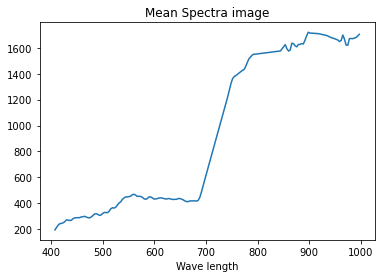

In [14]:
#compute mean of all spectra
avg_spectra1 = hyperim.mean(axis=0)
avg_spectra2 = avg_spectra1.mean(axis=0).reshape(-1,1)
plt.figure()
plt.title("Mean Spectra image")
plt.xlabel("Wave length")
plt.plot(all_wavelengths, avg_spectra2 )
plt.show()

#### Comment on the Mean spectra image with the average of 3 points
- The spectral of the vegetation dominates the mean spectra, because the vegetaion ratio in this image is comparatively greater than the rest.

# Task7 histogram of all the NDVI
Compute and display a histogram of all the NDVI values in the image, include it in the report.\
link: https://earthobservatory.nasa.gov/features/MeasuringVegetation



##### Facts about the NDVI valus:
- High values (0.66 to 1) represent very healthy plants
- Moderate values (0.33 to 0.66 ) represent moderately healthy plants
- Very low values of NDVI (0.1 and below) correspond to barren areas of rock, sand, or snow. Negative values are often water.

#####  Comment on the Histogram
From the histogram, we can see that -
- from (-0.1 to 0.19), we can see a peak in the pixel count which represents roads, roof tops and other objects found in the image.
- from (0.2 to 0.3), there are few pixel counts. So we have very few moderately healthy plants 
- from (0.7 to 0.9), we can see a peak in the pixel count which represents high number of healthy vegetation found in the image.


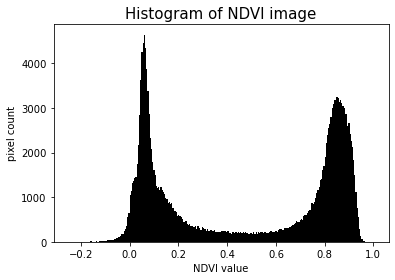

<Figure size 576x360 with 0 Axes>

In [15]:
# Creating histogram
plt.hist(ndvi_image_manual.ravel(),bins=256, range=[-0.25,1], color='black'); 
plt.title("Histogram of NDVI image", fontsize=15)
plt.xlabel("NDVI value")
plt.ylabel("pixel count")
plt.figure(figsize=(8,5))
plt.show()

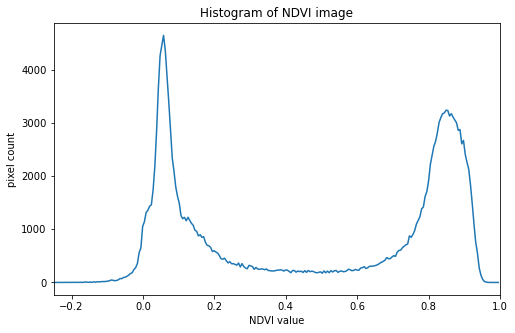

In [16]:
histogram, bin_edges = np.histogram(ndvi_image_manual, bins=256, range=(-.25, 1))

plt.figure(figsize=(8,5))
plt.title("Histogram of NDVI image")
plt.xlabel("NDVI value")
plt.ylabel("pixel count")
plt.xlim([-0.25, 1.0])  
plt.plot(bin_edges[0:-1], histogram)  
plt.show()

# Task8 Thresholding NDVI
Make a threshold of NDVI > 0.6 and set all values with NDVI > 0.6 to zero. Display this image. What do you see ? (include in report)

# Task9: Findig vegetation from the image
Can you use this information to determine the fraction area of the image that has vegetation ?


### Comment on Thresholed NDVI image

- We know from the NDVI 0.33, everything is considered vegetation. High values (0.66 to 1) represent very healthy plants and moderate values (0.33 to 0.66 ) represent moderately healthy plants. 

- We have set the threholding value to 0.6 which means we only want to see the **healthy vegetation**.  

- All the healthy vegetation of the image is black and rest of the elements of the image is white.

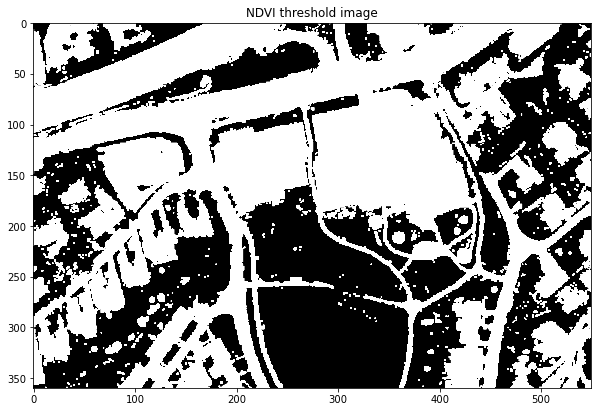

In [17]:
#Thresholding NDVI
threshold = 0.6 
ndvi_image_manual[ndvi_image_manual > threshold] = 0
ndvi_image_manual[ndvi_image_manual != 0] = 255

#Displaying the NDVI image
plt.subplots(1,1,figsize=(10,8))
plt.imshow(ndvi_image_manual,vmin=0,vmax=1, cmap='gray') 
plt.title("NDVI threshold image")
plt.show()

# Task10 
10. Carry out a principal component analysis (PCA) of the image, using the pca function from the Spectral Python.\
Study the score images  and loading plots.\
Can any of the first 3 components be used to identify vegetation in the image ?\
Include the **first 3 score** images and loading plots in your report.



## PCA plot and PCA image

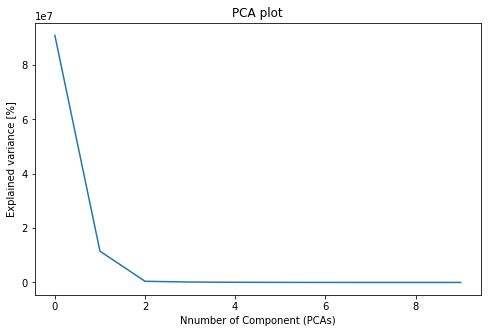

In [18]:
# Generating PCA plot to explain the variance present in the image
pc = principal_components(hyperim)
plt.figure(figsize=(8,5))
plt.plot(pc.eigenvalues[0:10])
plt.title("PCA plot")
plt.xlabel('Nnumber of Component (PCAs)')
plt.ylabel('Explained variance [%]')
plt.show()

#### Comment on the PCA plot:
- From the image below, we can see that, according to the **"Elbow method"**, only the **1st three PCAs** are enough to explain the variance in the image.


Number of PCA's selected 3


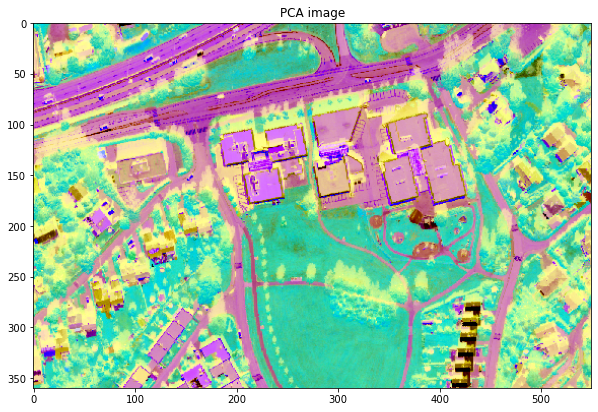

In [19]:
# PCA iamge calculation
pc_0994 = pc.reduce(fraction=0.994)# select the PC with 99.4% variance-
img_pc = pc_0994.transform(hyperim) # then transforming that PC with 99.4% to our original image
print("Number of PCA's selected", img_pc.shape[2])
imshow(img_pc, stretch=((0.02,0.98),(0.02,0.98),(0.02,0.98)), figsize=(10,8), title ='PCA image')
plt.show()

#### Comment on the PCA image:
- From the PCA image, we can see that the grassland has been represented in the 'green' and the trees have been represented in the 'cyan'. So, this PCA image can successfully identify the vegetation present in the image
- **Problem:** Few of the "dark green vegetation(trees)" has been misidentified as "rooftops".

## First 3 PCA score plots

In [20]:
# fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (14, 7))
# ax[0].imshow(img_pc[:,:,0], vmin=-0.1,vmax=0.15, cmap='gray')
# ax[0].set_title(r'PC0 image', fontsize = 13)

# ax[1].imshow(img_pc[:,:,1], vmin=-0.1,vmax=0.15, cmap='gray')
# ax[1].set_title(r'PC1 image', fontsize = 13)

# ax[2].imshow(img_pc[:,:,2], vmin=-0.1,vmax=0.15, cmap='gray')
# ax[2].set_title(r'PC2 image', fontsize = 13)


# for a in ax:
#     a.axis('off')

# fig.tight_layout()

# plt.show()

# finding max and min pixel value of a image

In [21]:
#finding max and min pixel value of a image
smallest = np.amin(img_pc[:,:,2])
biggest = np.amax(img_pc[:,:,2])
print("smallest ", smallest )
print("biggest", biggest)

smallest  -12207.011464715546
biggest 11752.950258412635


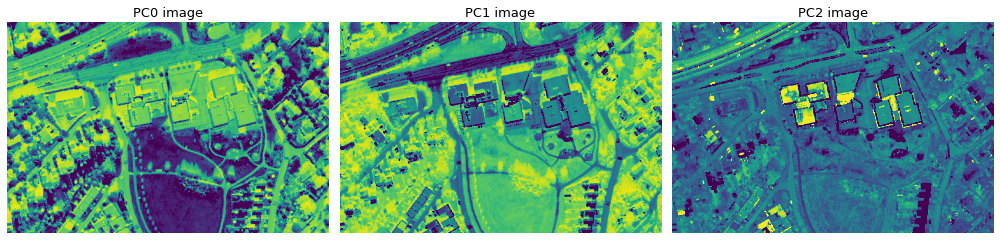

In [22]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (14, 7))
ax[0].imshow(img_pc[:,:,0], vmin=-14629,vmax=14646)
ax[0].set_title(r'PC0 image', fontsize = 13)

ax[1].imshow(img_pc[:,:,1], vmin=-6025,vmax=4065)
ax[1].set_title(r'PC1 image', fontsize = 13)

ax[2].imshow(img_pc[:,:,2], vmin=-500,vmax=1000)
ax[2].set_title(r'PC2 image', fontsize = 13)


for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

In [23]:
# fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (14, 7))
# ax[0].imshow(img_pc[:,:,0], vmin=-22000,vmax=10000)
# ax[0].set_title(r'PC0 image', fontsize = 13)

# ax[1].imshow(img_pc[:,:,1], vmin=-7500,vmax=4000)
# ax[1].set_title(r'PC1 image', fontsize = 13)

# ax[2].imshow(img_pc[:,:,2], vmin=-500,vmax=1000)
# ax[2].set_title(r'PC2 image', fontsize = 13)


# for a in ax:
#     a.axis('off')

# fig.tight_layout()
# plt.show()

##### Analysis of the PCA score plot images
- PC0 image has identied most of the vegetation (mainly grass)
- PC1 image has identied most of the roads and roof tops
- PC3 image has identied most of the shadows and green trees


# Understaing the loading plots
loadings corresponds to wavelenths. By looking at the wavelengths, we can understand which wavelengths have been given the weights for generating that score image


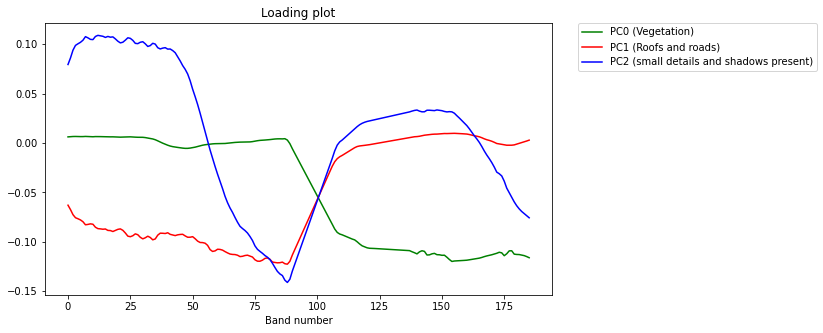

In [24]:
# loadings
loadings = pc_0994.eigenvectors 

#plotting the graph
fig, ax_dict = plt.subplot_mosaic([ ['bottom', 'BLANK']], empty_sentinel="BLANK", figsize = (20, 5))

ax_dict['bottom'].plot( loadings[:,[0]], color = 'g', label='PC0 (Vegetation)')
ax_dict['bottom'].plot( loadings[:,[1]], color = 'r', label='PC1 (Roofs and roads)')
ax_dict['bottom'].plot( loadings[:,[2]], color = 'b', label='PC2 (small details and shadows present)')
# Place a legend to the right of this smaller subplot.
ax_dict['bottom'].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


plt.title('Loading plot')
plt.xlabel('Band number')
# plt.ylabel("Pixel count")
plt.show()

##### Comment on the loading plot images
- PC0: vegetation (mainly grass)
- PC1: roads and roof tops
- PC3: shadows, small details and green trees

We know, the color green's band is 40. The PC0 line has a spike from 0 to 45 which mainly signifies the presense of the vegetation 

### Interpretation of the PCA images with their corresponding loading plots

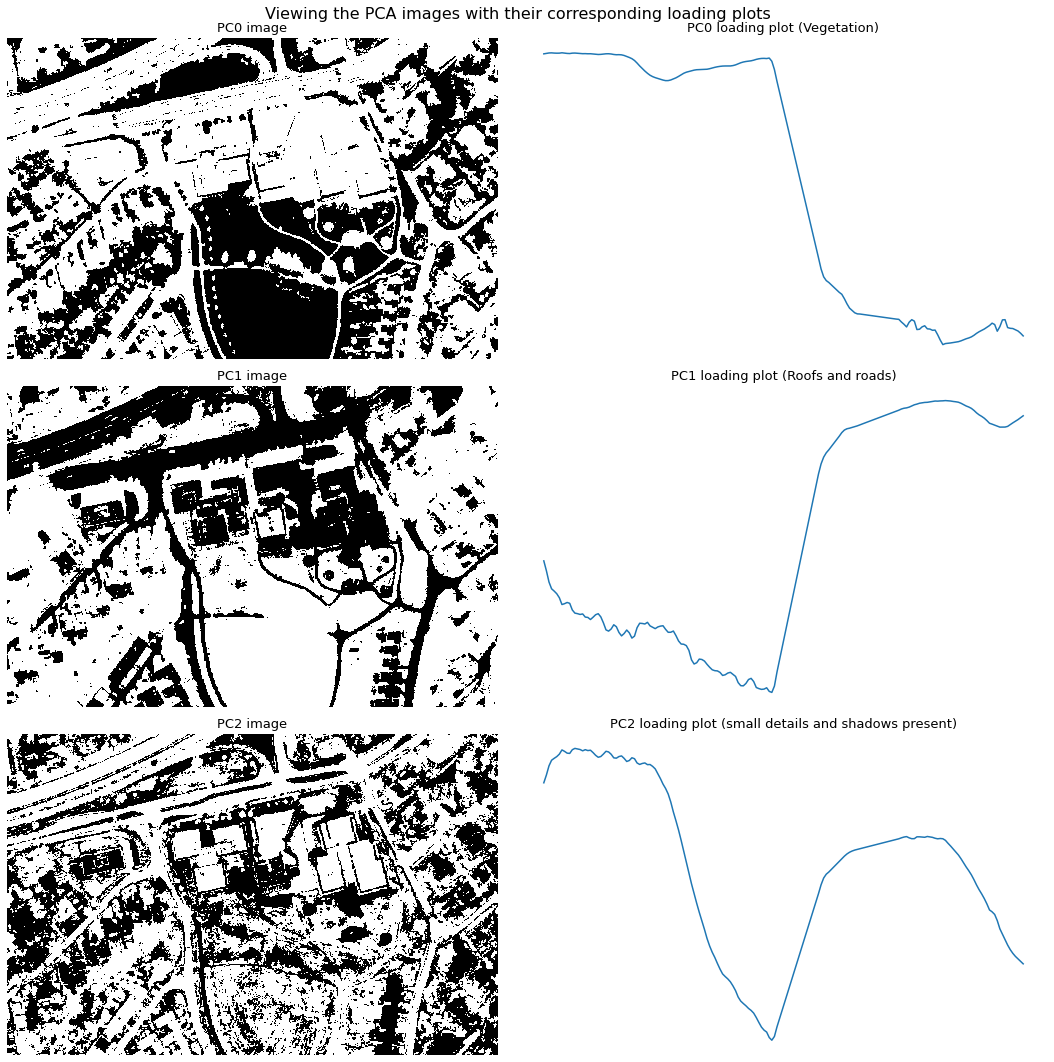

In [25]:
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 15)) #(width,height)
fig.suptitle("Viewing the PCA images with their corresponding loading plots", fontsize = 16)


ax[0, 0].imshow(img_pc[:,:,0], vmin=-0.1,vmax=0.15, cmap='gray')
ax[0, 0].set_title(r'PC0 image', fontsize = 13)

ax[0, 1].plot(loadings[:,[0]])
ax[0, 1].set_title(r'PC0 loading plot (Vegetation)', fontsize = 13)
 
    
    
ax[1, 0].imshow(img_pc[:,:,1], vmin=-0.1,vmax=0.15, cmap='gray')
ax[1, 0].set_title(r'PC1 image', fontsize = 13)

ax[1, 1].plot(loadings[:,[1]])
ax[1, 1].set_title(r'PC1 loading plot (Roofs and roads)', fontsize = 13)    
 
    

ax[2, 0].imshow(img_pc[:,:,2], vmin=-0.1,vmax=0.15, cmap='gray')
ax[2, 0].set_title(r'PC2 image', fontsize = 13)

ax[2, 1].plot(loadings[:,[2]])
ax[2, 1].set_title(r'PC2 loading plot (small details and shadows present)', fontsize = 13)   

for row in ax:
    for col in row:
        col.axis('off')

fig.tight_layout()
plt.show()


# Task11
Carry out a k-means clustering on a selected number of principal component score image, try k-means with 2, 3, 4 and 5 classes.\
How many components would you chose in order to group all the pixels with vegetation ? \
Include one of the k-mean calculations in the report.

## Analysis of kmeans clustering with the PCA Image(reduced elements/noises):

In [26]:
# For stopping the spectral information printing
import logging, sys
logging.disable(sys.maxsize)

In [27]:
#Function for calculating the clusters and displaying the result images
def k_means_analysis(image, cluster_number, vmin, vmax):
    
    (m,c) = kmeans(image, cluster_number, 30) 
    
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 6))
    fig.suptitle("K-means clustering with "+str(cluster_number)+" clusters", fontsize = 14)
    
        #finding max and min pixel value of a image
    smallest = np.amin(m)
    biggest = np.amax(m)
    print("smallest ", smallest )
    print("biggest", biggest)
    
    ax[0].set_title(r'Clustering image ('+str(cluster_number)+" clusters)", fontsize = 13)
    ax[0].imshow(m, cmap ='jet', vmin = vmin, vmax= vmax)

    ax[1].set_title(r'Loading plot', fontsize = 13)
    for i in range(c.shape[0]):
        ax[1].plot(c[i])
    
    
    fig.tight_layout()
    plt.show()

##### For k-means clustering with 2 clusters: 
- Successfully identified the grass. The grass is represented in dark blue color.

smallest  0
biggest 1


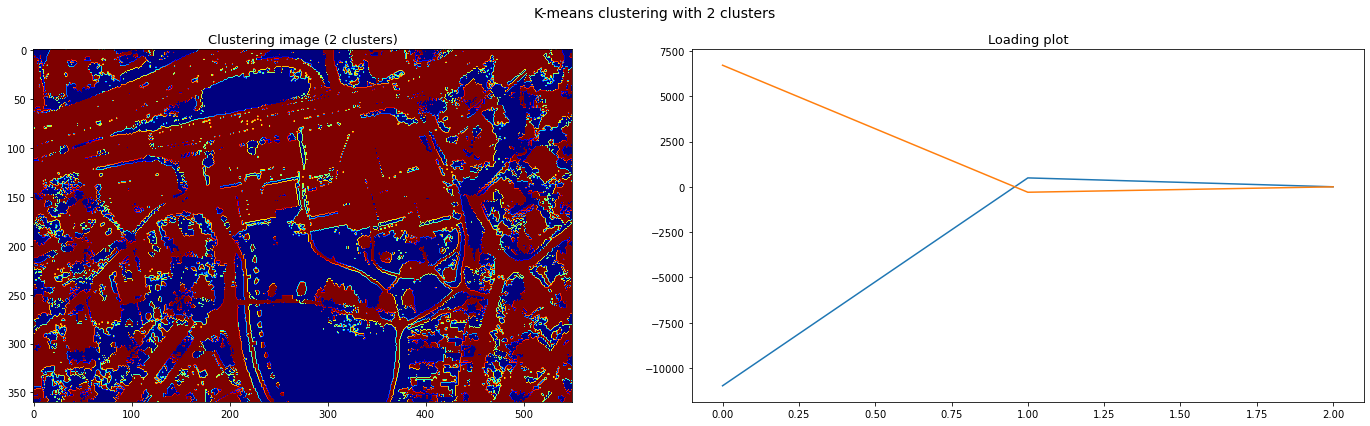

In [28]:
# 2-clusters, 30-no of iterations--On the selected PCs
k_means_analysis(img_pc, 2, vmin=0, vmax=1)


##### For k-means clustering with 3 clusters: 
- Sucessfully identified the grass. The grass is represented in cyan color.


smallest  0
biggest 2


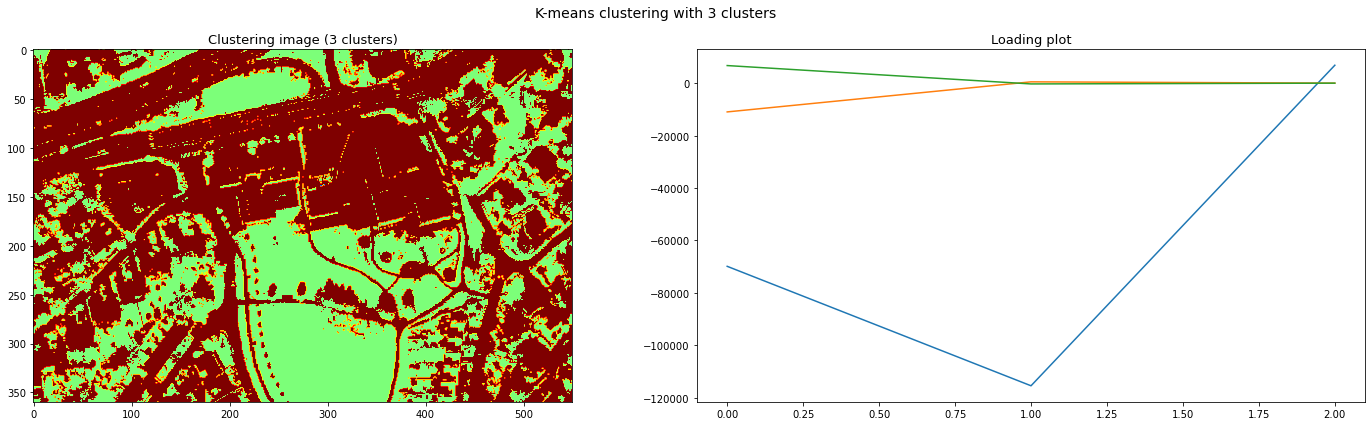

In [29]:
# 3-clusters, 30-no of iterations--On the selected PCs
k_means_analysis(img_pc, 3, vmin=0, vmax=2)

##### For k-means clustering with 4 clusters: 
- Sucessfully identified the grass, roads and few roof tops(red & light-reflecting/shiny) present in the image. 
   - The grass is represented in yellow color. 
   - The red rooftops are represented in Cyan color.
   - roads and concrete roads in brown color


smallest  0
biggest 3


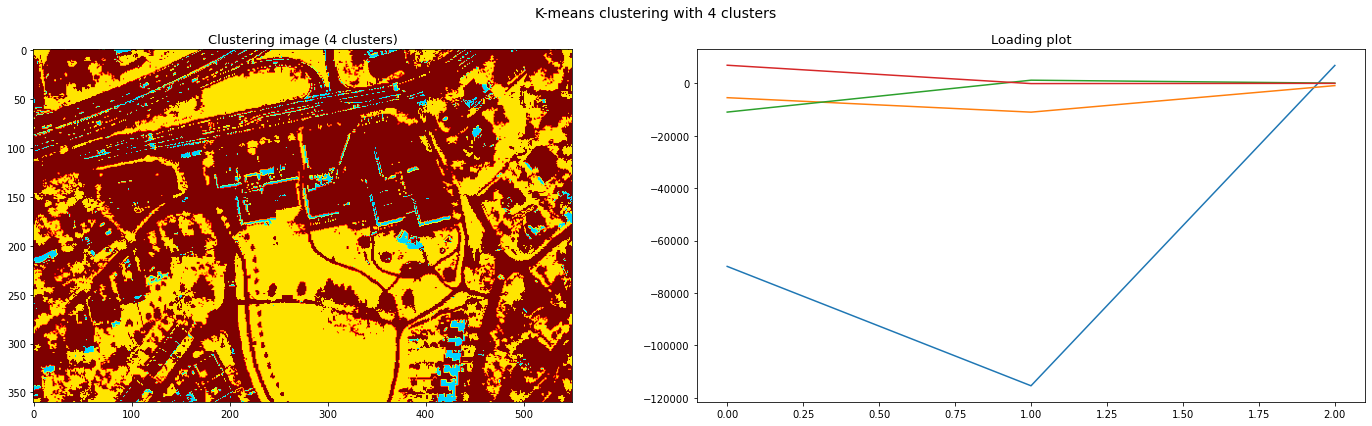

In [30]:
# 4-clusters, 30-no of iterations--On the selected PCs
k_means_analysis(img_pc, 4, vmin=0, vmax=3)

##### For k-means clustering with 5 clusters: 
- Sucessfully identified the grass, a few roof tops, and roads present in the image. 
  - The grass has been represented in orange color. 
  - The red & light-reflecting/shiny roof tops have been represented in cyan color. 
  - The light colored roads have been represented in lime color.
  - Narrow roads and concrete roof tops have been presented in dark brown color
- **Problem:** Few of the "dark green vegetation(trees)", "narrow roads" and "concrete roof tops" have been classified in the same color/group.

**The k-means clustering with 5 clusters is the best option among the other k-means clutering options**


smallest  0
biggest 4


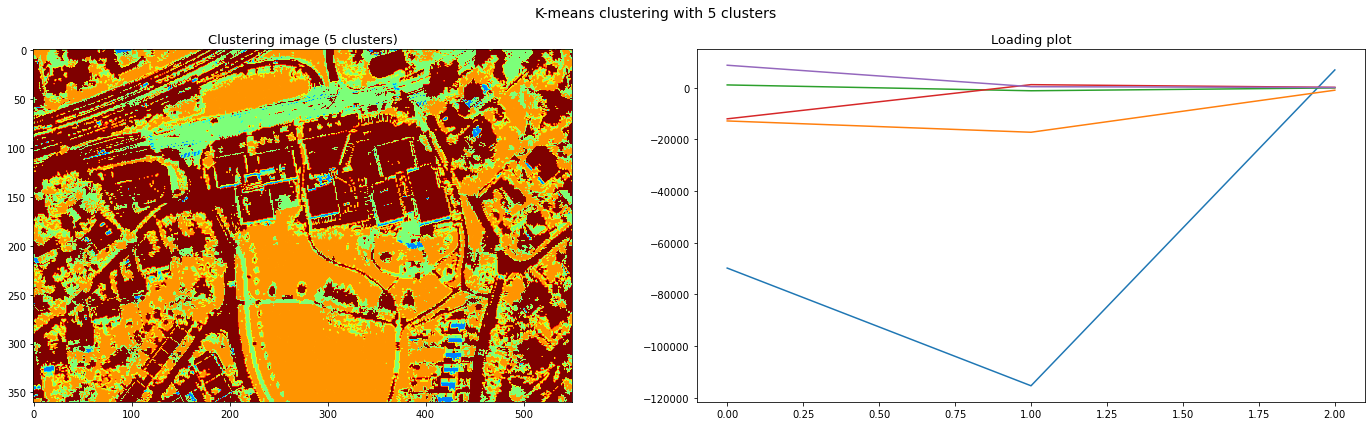

In [31]:
# 5-clusters, 30-no of iterations--On the selected PCs
k_means_analysis(img_pc, 5, vmin=0, vmax=4)

## Analysis of kmeans clustering with the Original Image:

smallest  0
biggest 4


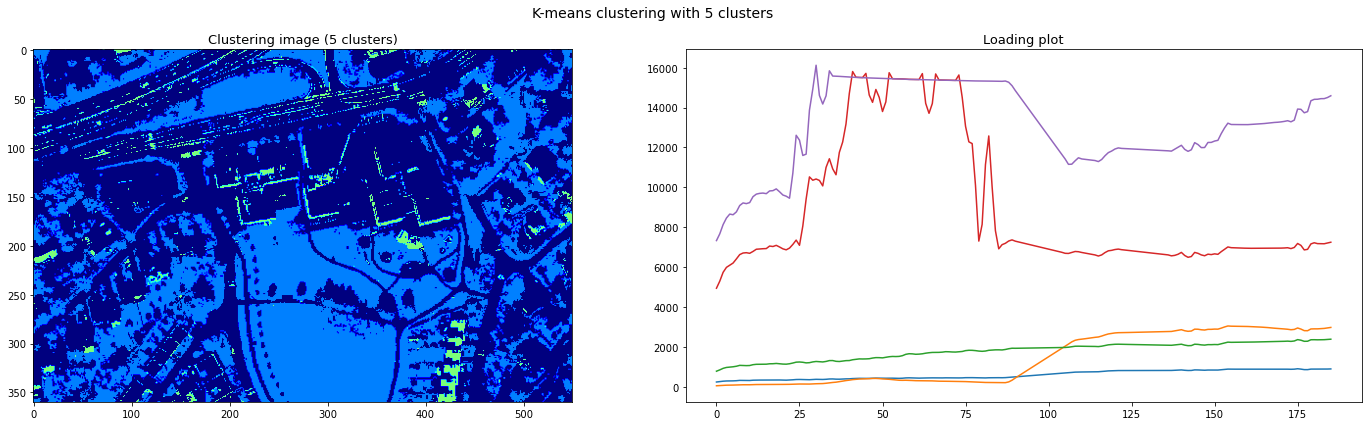

In [32]:
# 5-clusters, 30-no of iterations--On the Original image
k_means_analysis(hyperim, 5, vmin=0, vmax=4)

### Comment on the clustering on the original image and the loading plot.
- Sucessfully identified the grass, a few roof tops, and roads present in the image. 
  - The glass has been represented in light blue color. 
  - The red & light-reflecting/shiny roof tops have been represented in cyan color. 
  - The concrete roof tops, trees, light colored roads and few of the shadows have been represented in dark blue color. 

- **Problem:** Few of the "dark green vegetation(trees)", narrow roads and concrete roof tops have been classified in the same color/group.

### Best betweens the k-means clustering on the PCA image and the original image

- **Clustering image**:
   - Irrelevant information present in the original image, makes it impossible to cluster properly, specially in distinguishing among the "dark green vegetation(trees)", "light colored roads", and "concrete roof tops". 
   - The PCA image also suffers from the same problem, but was sucessfull in distinguishing in more features present in the image compared to the original image.
- **Loading plot**:
   - The loading plot of the original image is much noisy and difficult to understand compared to the loading plot of the PCA image

## Gaussian Maximum Likelihood Classification (GMLC)


<function matplotlib.pyplot.show(close=None, block=None)>

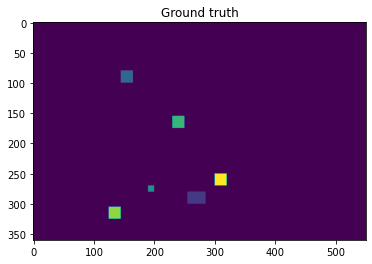

In [33]:
#creating the ground truth image
shape = hyperim.shape
groundtruth = np.zeros([shape[0],shape[1]])
groundtruth[280:300, 255:285] = 1.0   #grass
groundtruth[250:270, 300:320] = 6.0   #dark tree
groundtruth[80:100, 145:165] = 2.0 # asphalt--road-light
groundtruth[270:280, 190:200] = 3.0 # road-dark narrow
groundtruth[155:175,230:250] =4.0 #brown roof
groundtruth[305:325, 125:145] =5.0 #dark roof left


#displaying the ground truth image
plt.figure()
plt.title("Ground truth")
plt.imshow(groundtruth)
plt.show

Processing...  0.0Processing... 20.0Processing... 40.0Processing... 60.0Processing... 80.0Processing... 100.Processing...done   


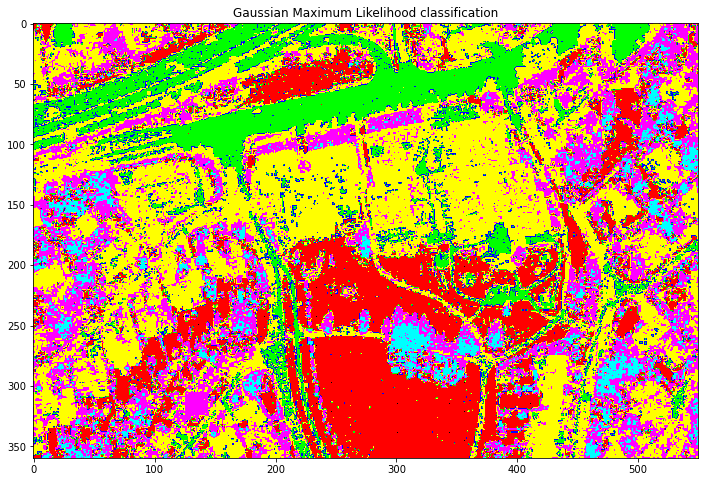

In [34]:
# Gaussian Maximum Likelihood classification
classes = create_training_classes(hyperim, groundtruth)
gmlc = GaussianClassifier(classes)
clmap = gmlc.classify_image(hyperim)


imshow(classes=clmap, figsize=(12,8))
plt.title("Gaussian Maximum Likelihood classification")
plt.show()

# Task-12 
Which method to determine the amount of vegetation do you think is most appropriate in this hyperspectral image ? Describe why you prefer one method before another.

## Methods for identifing vegetation in the hyperspectral image



#### Method1:  NDVI Image
- All the vegetation of the image is green and rest of the elements of the image is red.
- **BEST OPTION**: Vegetation can be easily identified and very few misclassifications

#### Method2:  NDVI Thresholded image
- All the vegetation of the image is black and rest of the elements of the image is white.
- **BEST OPTION**: Vegetation can be easily identified and very few misclassifications

#### Method3: PCA Image
- Successfully identifies the vegetation present in the image
- **Problem:** Few of the "dark green vegetation(trees)" has been misidentified as "rooftops".

#### Method4: K-means clustering
- Sucessfully identified the grass, a few roof tops, and roads present in the image for cluster=5. 
- **Problem:** Few of the "dark green vegetation(trees)" has been misclassified as "rooftops".

#### Method5: Gaussian Maximum Likelihood Classification (GMLC)

#### Hence, NDVI thresholding is the best option for identifying vegetation present in the given image